### About
### Estimate AOD using Sentinel-2 data, leveraging its spectral bands and spatial resolution to improve accuracy.
### Competition hosted on [Solafune](https://solafune.com/competitions/ca6ee401-eba9-4f7d-95e6-d1b378a17200?menu=about&tab=overview)

### Competition Policy
### cf. @solafune(https://solafune.com) Use for any purpose other than participation in the competition or commercial use is prohibited. If you would like to use them for any of the above purposes, please contact us.

### Import necessary library and packages

In [1]:
!pip install imagededup distance klib imagecodecs -qq

In [2]:
import pandas as pd #dataframe manipulation
import numpy as np  #for numerical process
import seaborn as sns #for visualization
from matplotlib import pyplot as plt #for visualization
from PIL import Image, ImageDraw, ImageEnhance,ImageStat #for read the image
import skimage.color 
import skimage.io as skio
from skimage.transform import resize
import skimage.util
from skimage.measure import shannon_entropy, blur_effect
import imagehash #for calculation hash value of image
import cv2 #for read the image
import re
import os
import itertools
import os
import distance
import time
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm_notebook,tqdm
from IPython.display import display, HTML
import tifffile
import torch
import shutil
from tqdm import tqdm_notebook
from PIL import Image, ImageDraw #for read the image
import skimage.color 
import skimage.util
import imagehash #for calculation hash value of image
import cv2 #for read the image
import os
import re
import itertools
#import distance
import time
import warnings
warnings.filterwarnings("ignore")
from sklearn.neighbors import KNeighborsClassifier
from torchvision import transforms
from multiprocessing import Pool
import torch.nn.functional as F
import klib
import imagededup
from imagededup.methods import PHash
from scipy.stats import skew, kurtosis
from skimage import io, filters
from skimage.feature import graycomatrix, graycoprops
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
phasher = PHash()

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 133MB/s]


### About Data
#### The images are from the optical satellite Sentinel-2.
#### The Sentinel-2 image contains information on following 13 bands:
#### B1: Aerosols
#### B2: Blue
#### B3: Green
#### B4: Red
#### B5: Red Edge 1
#### B6: Red Edge 2
#### B7: Red Edge 3
#### B8: NIR
#### B8A: Red Edge 4
#### B9: Water vapor
#### B10: SWIR Cirrus
#### B11: SWIR 1
#### B12: SWIR 2

#### [Data source](https://solafune.com/competitions/ca6ee401-eba9-4f7d-95e6-d1b378a17200?menu=data&tab=)
#### [Data source](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED#bands)
#### [Data source](https://aeronet.gsfc.nasa.gov/)

### Import data

In [3]:
train = pd.read_csv("/kaggle/input/solafune-aerosol-optical-depth-estimation/train_answer.csv",header=None)
train.columns = ['filename','location','label']


test = pd.DataFrame({'filename':[f"test_{i}.tif" for i in range(1,1490)]})


train_image_path = "/kaggle/input/solafune-aerosol-optical-depth-estimation/train_images/train_images/"
test_image_path = "/kaggle/input/solafune-aerosol-optical-depth-estimation/test_images/test_images/"

### Train and test data summary

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4465 entries, 0 to 4464
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  4465 non-null   object 
 1   location  4465 non-null   object 
 2   label     4465 non-null   float64
dtypes: float64(1), object(2)
memory usage: 104.8+ KB


#### Train dataset has 4464 images

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1489 entries, 0 to 1488
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  1489 non-null   object
dtypes: object(1)
memory usage: 11.8+ KB


#### Test dataset has 1489 images

#### Let's examine the distribution of target column

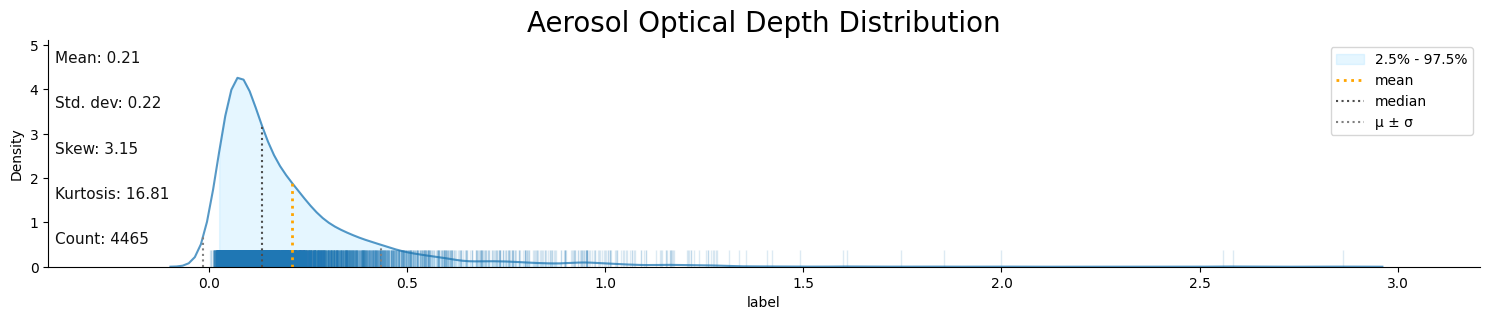

In [6]:
klib.dist_plot(train['label']);  
plt.title("Aerosol Optical Depth Distribution",fontsize=20);

In [7]:
def box_plot(df,col, title=""):
  _=plt.figure(figsize=(8,4))
  _=sns.boxplot(x=df[col],color="Green")
  _=plt.title(f"{title}\n",fontsize=14)
  _=plt.xlabel(col,fontsize=12)
  _=plt.xticks(fontsize=14)

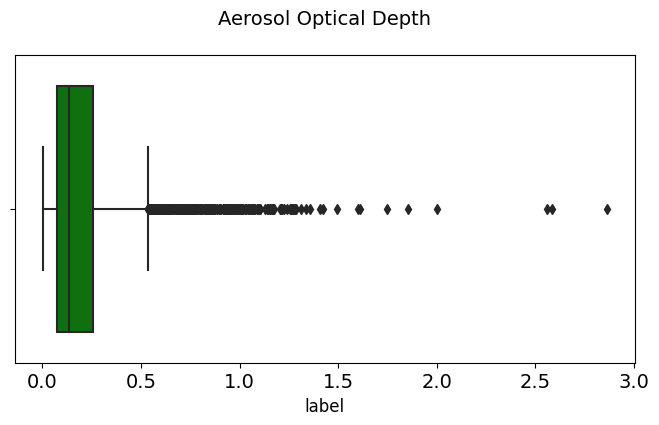

In [8]:
box_plot(train,'label', title="Aerosol Optical Depth")

In [9]:
train['label'].describe()

count    4465.000000
mean        0.209845
std         0.224224
min         0.003571
25%         0.073370
50%         0.133372
75%         0.257629
max         2.860874
Name: label, dtype: float64

#### The above plot explains the distribution of aerosol optical depth is positively skewed.
#### The average aerosol optical depth is 0.21.
#### The aerosol optical depth ranges from 0.004 to 2.86.
#### The boxplot explains that there are outliers above the third quartile.

### Sample image

In [10]:
bands = {'B1_Aerosols':0,'B2_Blue':1,'B3_Green':2,'B4_Red':3,
'B5_Red_Edge_1':4,'B6_Red_Edge_2':5,'B7_Red_Edge_3':6,
'B8_NIR':7,'B8A_Red_Edge_4':8,'B9_Water_vapor':9,'B10_SWIR_Cirrus':10,'B11_SWIR_1':11,
'B12_SWIR_2':12}

### Band colors

In [11]:
color_list = {
    'B1_Aerosols': 'Blues',
    'B2_Blue': 'Blues',
    'B3_Green': 'Greens',
    'B4_Red': 'Reds',
    'B5_Red_Edge_1': 'Oranges',
    'B6_Red_Edge_2': 'Oranges',
    'B7_Red_Edge_3': 'Oranges',
    'B8_NIR': 'YlGnBu',
    'B8A_Red_Edge_4': 'Oranges',
    'B9_Water_vapor': 'Blues',
    'B10_SWIR_Cirrus': 'cool',
    'B11_SWIR_1': 'gray',
    'B12_SWIR_2': 'gray'}

bandclr=list(color_list.values())

In [12]:
def get_key_from_value(dictionary, target_value):
    for key, value in dictionary.items():
        if value == target_value:
            return key
    return None

In [13]:
def plot_sample_image(path,filename,figure_size=(10,15)):
    fig=plt.figure(figsize=figure_size)
    img=tifffile.imread(f"{path}{filename}")
    for i,(band,clr) in enumerate(zip(bands.values(),bandclr)):
        ax=plt.subplot(5,3,i+1)
        ax.imshow(img[:,:,band],aspect='auto',cmap=clr)
        ax.set_title(f"{get_key_from_value(bands, band)}",fontsize=15)
        ax.axis("off")
        ax.set_aspect('auto')
    #plt.tight_layout()
    plt.show()

### Sample images of minimum and maximum aerosol optical depth across 13 bands

#### Minimum AOD

In [14]:
train[train['label']==train['label'].min()]['filename']

2679    train_2680.tif
Name: filename, dtype: object

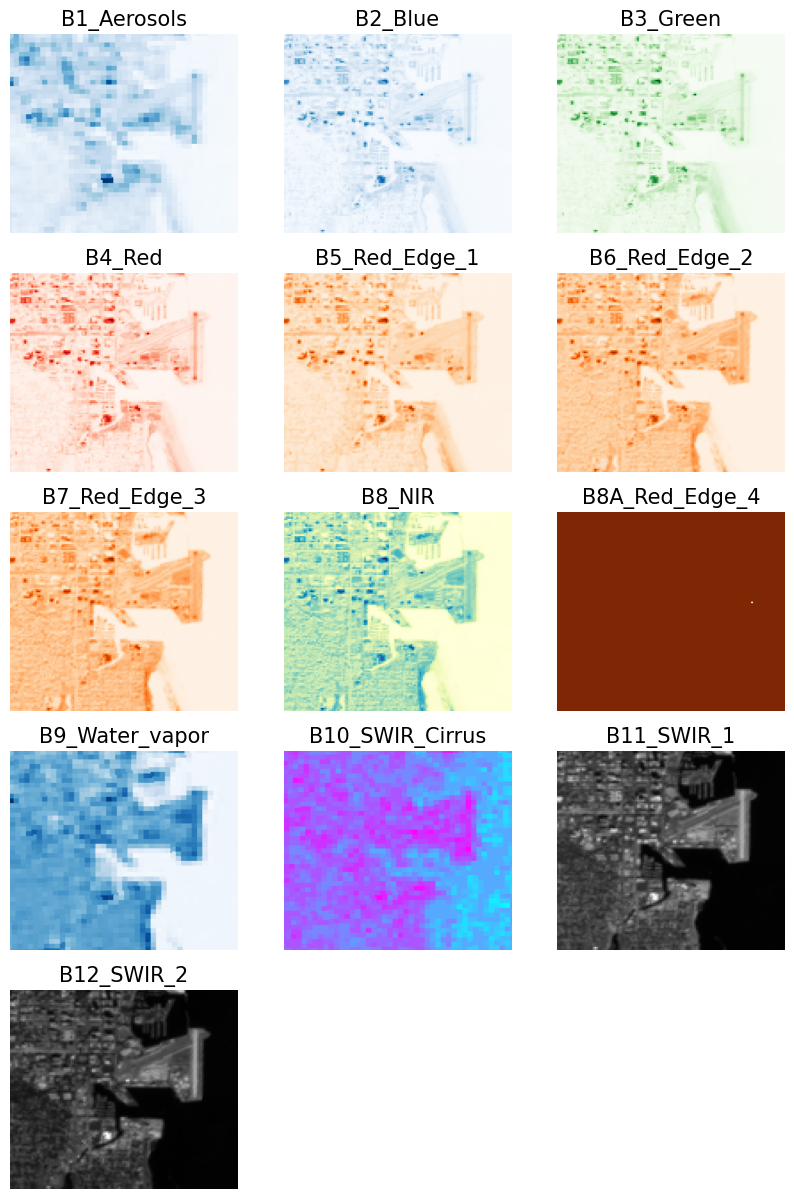

In [15]:
plot_sample_image(train_image_path,'train_2680.tif',figure_size=(10,15))

#### Maximum AOD

In [16]:
train[train['label']==train['label'].max()]['filename']

3147    train_3148.tif
Name: filename, dtype: object

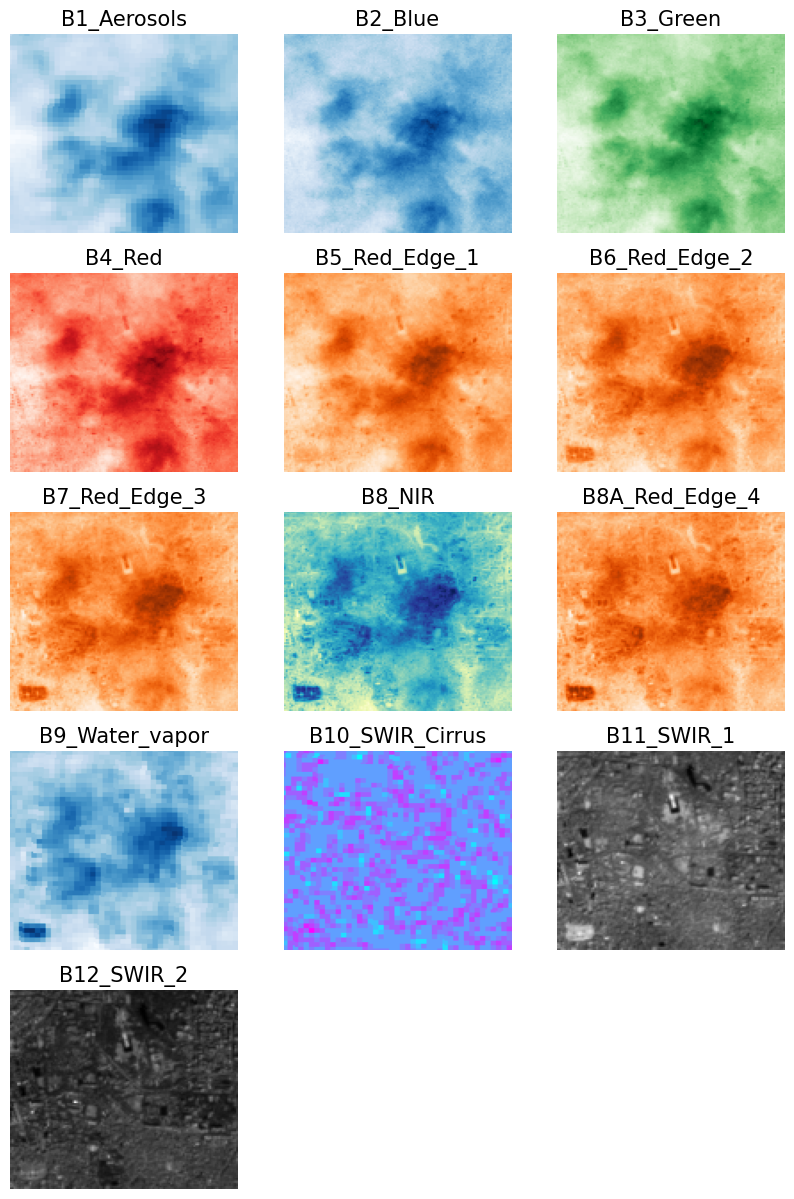

In [17]:
plot_sample_image(train_image_path,'train_3148.tif',figure_size=(10,15))

### Extract 1D array from each bands

In [18]:
def get_band_1d(df,path):
    b1,b2,b3,b4,b5,b6,b7,b8,b8a,b9,b10,b11,b12=([] for _ in range(13))
    for file in tqdm_notebook(df['filename']):
        img=tifffile.imread(f"{path}{file}")
        img=resize(img, (64, 64), anti_aliasing=True)
        for band,lists in zip(range(13),[b1,b2,b3,b4,b5,b6,b7,b8,b8a,b9,b10,b11,b12]):
            lists.append(list(img[:,:,band].flatten()))
    return {f"b{key}":lists  for key ,lists in zip(range(1,14), [b1,b2,b3,b4,b5,b6,b7,b8,b8a,b9,b10,b11,b12])}
  

In [19]:
channel_1d_data=get_band_1d(train,train_image_path)

  0%|          | 0/4465 [00:00<?, ?it/s]

### Let's visualize the histogram of 13 bands for mining site images.

In [20]:
def show_histogram(data,figure_size=(15,10)):
    fig=plt.figure(figsize=figure_size)
    custom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',
                 '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#17becf', '#ff00ff', '#00ff00']
 
        
    for i,(band,bandname,clr) in enumerate(zip(range(1,14),list(bands.keys()),custom_colors)):
        _=plt.subplot(5,3,i+1)
        
        data=np.concatenate(channel_1d_data[f"b{band}"])
        plt.hist(data,color=clr, histtype="step",bins=2);
        plt.title(f"{bandname}",fontsize=15)
        del data
    plt.tight_layout()
    plt.show()

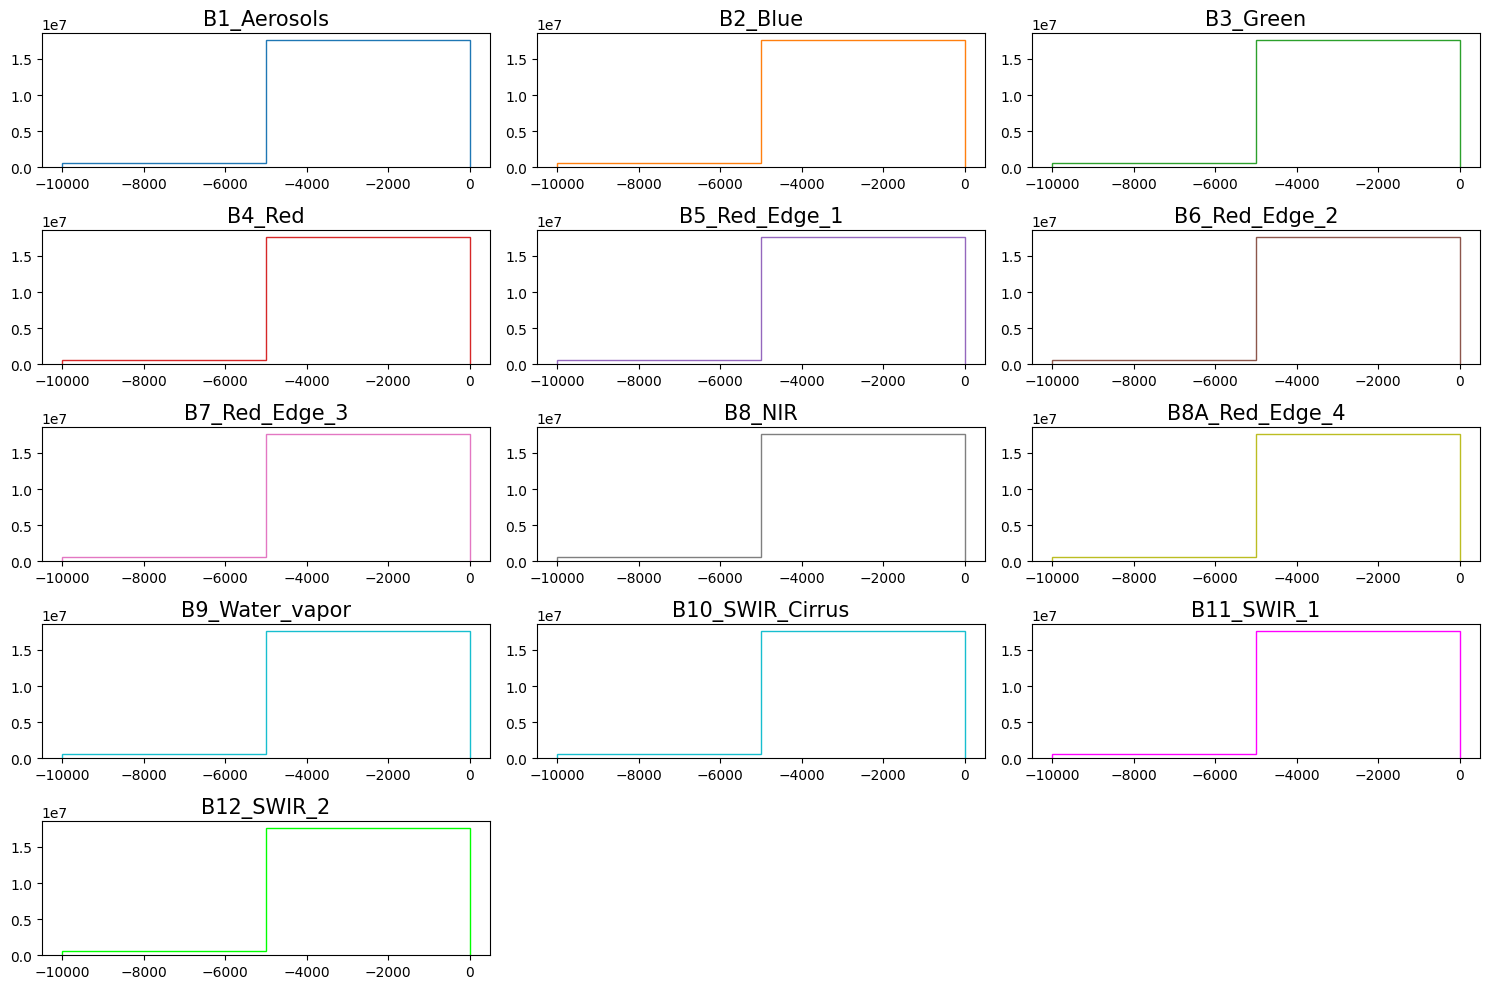

In [21]:
show_histogram(channel_1d_data)

### Let's explore popular RGB composites for minimum and maximum AOD

In [22]:
band_combo={'Natural Colors':[bands['B4_Red'],bands['B3_Green'],bands['B2_Blue']],
'False color Infrared':[bands['B8_NIR'],bands['B4_Red'],bands['B3_Green']],
'False color Urban':[bands['B12_SWIR_2'],bands['B11_SWIR_1'],bands['B4_Red']],
'Agriculture':[bands['B11_SWIR_1'],bands['B8_NIR'],bands['B12_SWIR_2']],
'Atmospheric penetration':[bands['B12_SWIR_2'],bands['B11_SWIR_1'],bands['B8A_Red_Edge_4']],
'Healthy vegetation':[bands['B8_NIR'],bands['B11_SWIR_1'],bands['B12_SWIR_2']],
'Land/Water':[bands['B8_NIR'],bands['B11_SWIR_1'],bands['B4_Red']],
'Natural Colors with Atmospheric Removal':[bands['B12_SWIR_2'],bands['B8_NIR'],bands['B3_Green']],
'Shortwave Infrared':[bands['B12_SWIR_2'],bands['B8_NIR'],bands['B4_Red']],
'Vegetation Analysis':[bands['B11_SWIR_1'],bands['B8_NIR'],bands['B4_Red']]}


composites_color_maps = {
    'Natural Colors': 'viridis',
    'False color Infrared': 'YlGnBu',
    'False color Urban': 'Oranges',
    'Agriculture': 'YlOrBr',
    'Atmospheric Penetration': 'Blues',
    'Healthy Vegetation': 'Greens',
    'Land/Water': 'coolwarm',
    'Natural Colors with Atmospheric Removal': 'plasma',
    'Shortwave Infrared': 'bone',
    'Vegetation Analysis': 'Greens',
}

In [23]:
def plot_rgb_composites(path,filename,figure_size=(15,10)):
    fig=plt.figure(figsize=figure_size)
    img=tifffile.imread(f"{path}{filename}")
    for i,(band,clr) in enumerate(zip(band_combo.keys(),list(composites_color_maps.values()))):
        ax=plt.subplot(5,2,i+1)
        cols=[band_combo[band][0],band_combo[band][1],band_combo[band][2]]
   
        ax.imshow(np.dstack((img[:,:,cols[0]],
                          img[:,:,cols[1]],
                          img[:,:,cols[2]])),aspect='auto',cmap=clr)

       
        ax.set_title(f"{get_key_from_value(composites_color_maps, clr)}",fontsize=15)
        ax.axis("off")
       # ax.set_aspect('auto')
    #plt.tight_layout()
    plt.show()

### Minimum AOD

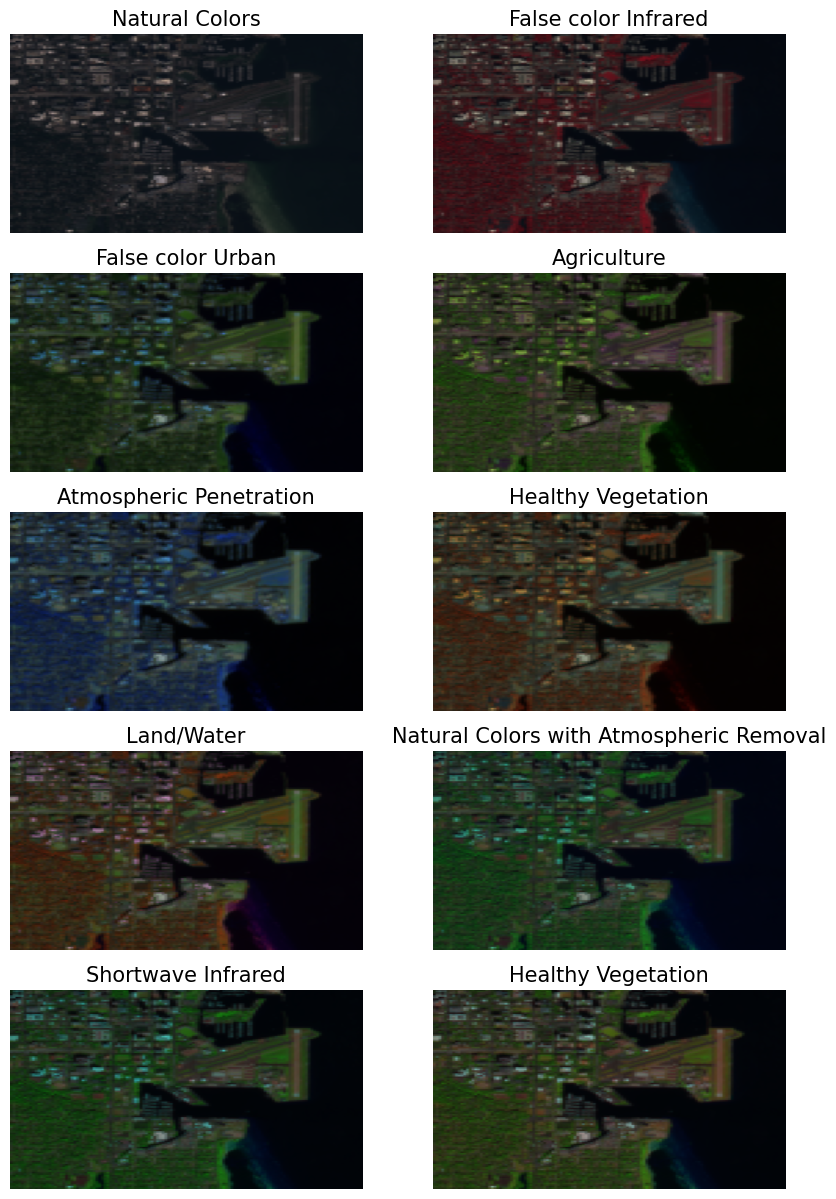

In [24]:
plot_rgb_composites(train_image_path,'train_2680.tif',figure_size=(10,15))

### Maximum AOD

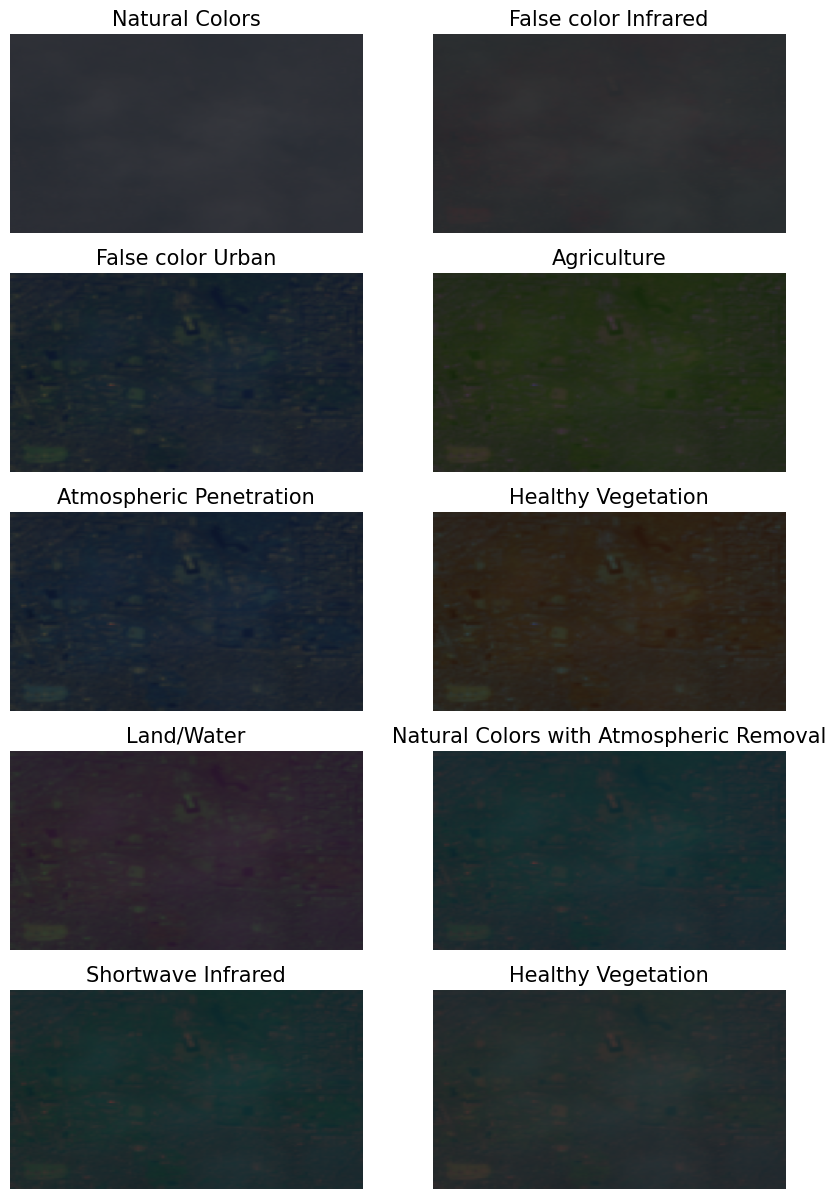

In [25]:
plot_rgb_composites(train_image_path,'train_3148.tif',figure_size=(10,15))

### Let's explore different spectral indices for minimum and maximum AOD.

In [26]:
def ndvi(image):
    #Normalized Difference Vegetation Index (NDVI) is a widely used vegetation index in remote sensing.
    #NDVI= NIR-Red/NIR+Red
    #image = np.expand_dims(image, axis=-1)
    ndvi_denominator = image[:,:,bands['B3_Green']]+image[:,:,bands['B8_NIR']]
    
    ndvi = (image[:,:,bands['B3_Green']]-image[:,:,bands['B8_NIR']]) / ndvi_denominator
    return ndvi
    
def ndwi(image):
    #Normalized Difference Water Index (NDWI) is a spectral index commonly used to detect and monitor
    #water bodies in remote sensing imagery.
    #NDVI= NIR-Red/NIR+Red
    #image = np.expand_dims(image, axis=-1)
    ndwi_denominator =image[:,:,bands['B8_NIR']]+image[:,:,bands['B4_Red']]
    ndwi=(image[:,:,bands['B8_NIR']]-image[:,:,bands['B4_Red']])/ndwi_denominator
    return ndwi

def fmi(image):
    #Ferrous Mineral Index (FMI) is an indicator for iron-bearing minerals
    #FMI = Band11/
    #image = np.expand_dims(image, axis=-1)
    denominator=image[:,:,bands['B8A_Red_Edge_4']]
    fmi=image[:,:,bands['B11_SWIR_1']]/denominator#Ferrous Mineral Index-FMI
    return fmi
def msi(image):
    #Moisture Stress Index (MSI) is a vegetation index used to assess vegetation water stress based on remotely sensed data
    #MSI = B11 / B08
    #image = np.expand_dims(image, axis=-1)
    numerator = image[:,:,bands['B11_SWIR_1']]
    denominator = image[:,:,bands['B8_NIR']]
    msi =  numerator / denominator
    return msi

def bsi(image):
    #Bare Soil Index (BSI) is a spectral index commonly used for mapping bare soil or distinguishing between bare soil and vegetation
    #BSI= (SWIR+NIR)/(SWIR−NIR)
    #image = np.expand_dims(image, axis=-1)
    numerator = image[:,:,bands['B11_SWIR_1']] - image[:,:,bands['B8_NIR']]
    denominator = image[:,:,bands['B11_SWIR_1']] + image[:,:,bands['B8_NIR']]
    bsi = numerator / denominator
    return bsi

def nbr(image):
    #Normalized Burn Ratio (NBR) is a spectral index commonly used to assess and monitor burned areas, especially after wildfires.
    #NBR= (NIR+SWIR)/(NIR−SWIR)
   # image = np.expand_dims(image, axis=-1)
    numerator = image[:,:,bands['B8_NIR']] - image[:,:,bands['B12_SWIR_2']]
    denominator = image[:,:,bands['B8_NIR']] + image[:,:,bands['B12_SWIR_2']]
    nbr =  numerator / denominator
    return nbr

In [27]:
train[train['label']==train['label'].min()]['filename']

2679    train_2680.tif
Name: filename, dtype: object

In [28]:
train[train['label']==train['label'].max()]['filename']

3147    train_3148.tif
Name: filename, dtype: object

#### Minimum AOD

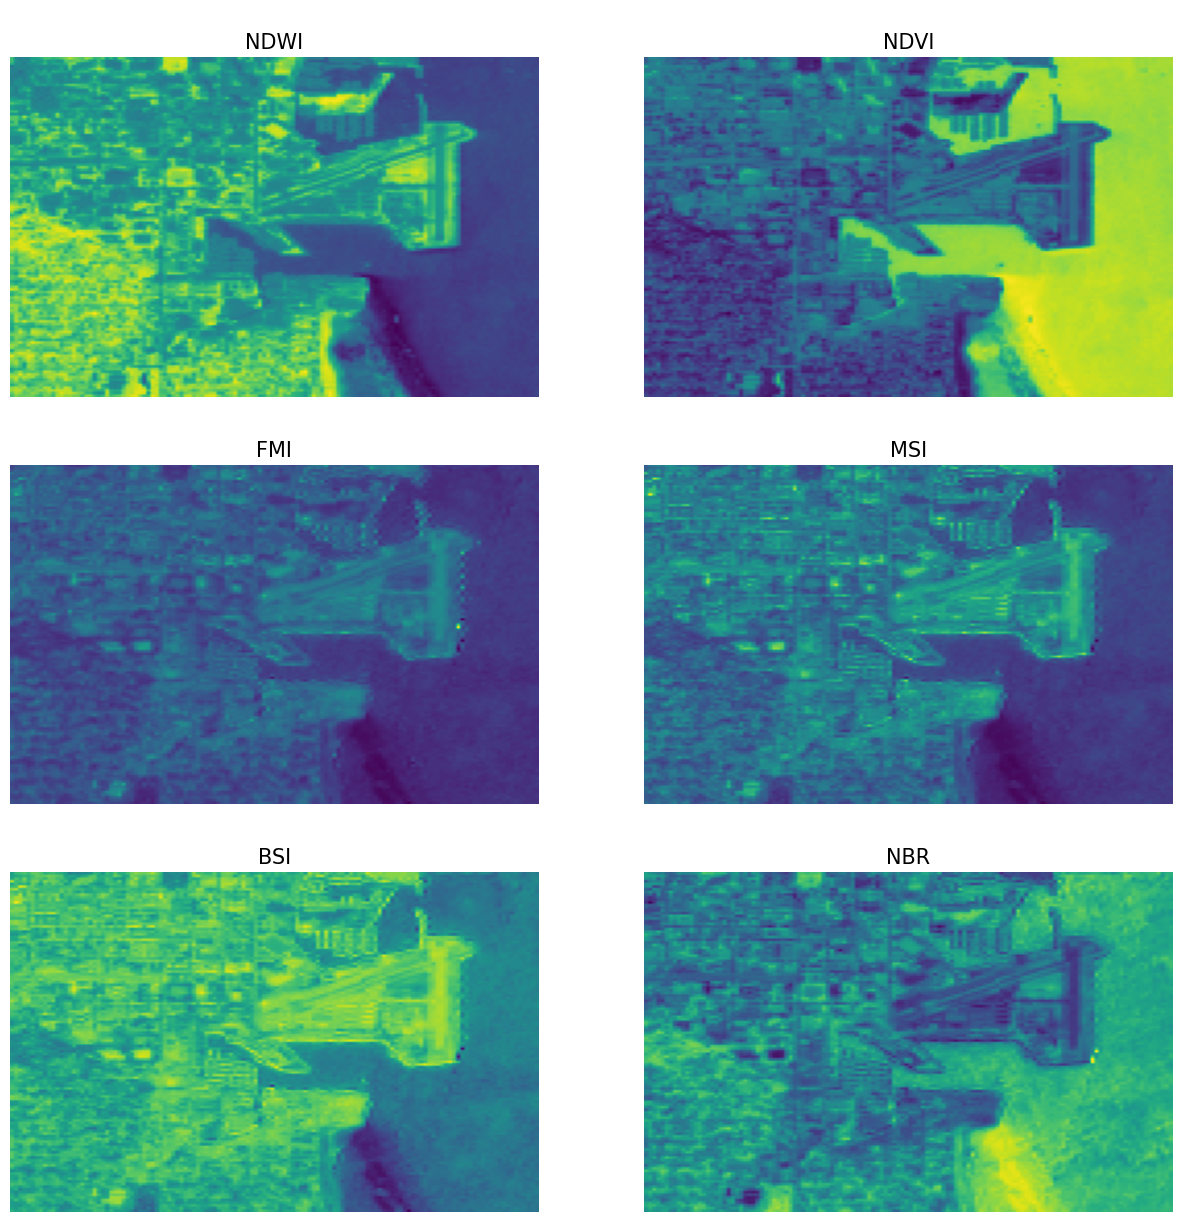

In [29]:
img = tifffile.imread(f"{train_image_path}{'train_2680.tif'}")
fig=plt.figure(figsize=(15,15))
for i,indices in enumerate((ndwi, ndvi, fmi, msi, bsi, nbr )):
    ax=plt.subplot(3,2,i+1)

    ax.imshow(indices(img), aspect='auto')


    ax.set_title(f"\n{indices.__name__.upper()}",fontsize=15)
    ax.axis("off")

#### Maximum AOD

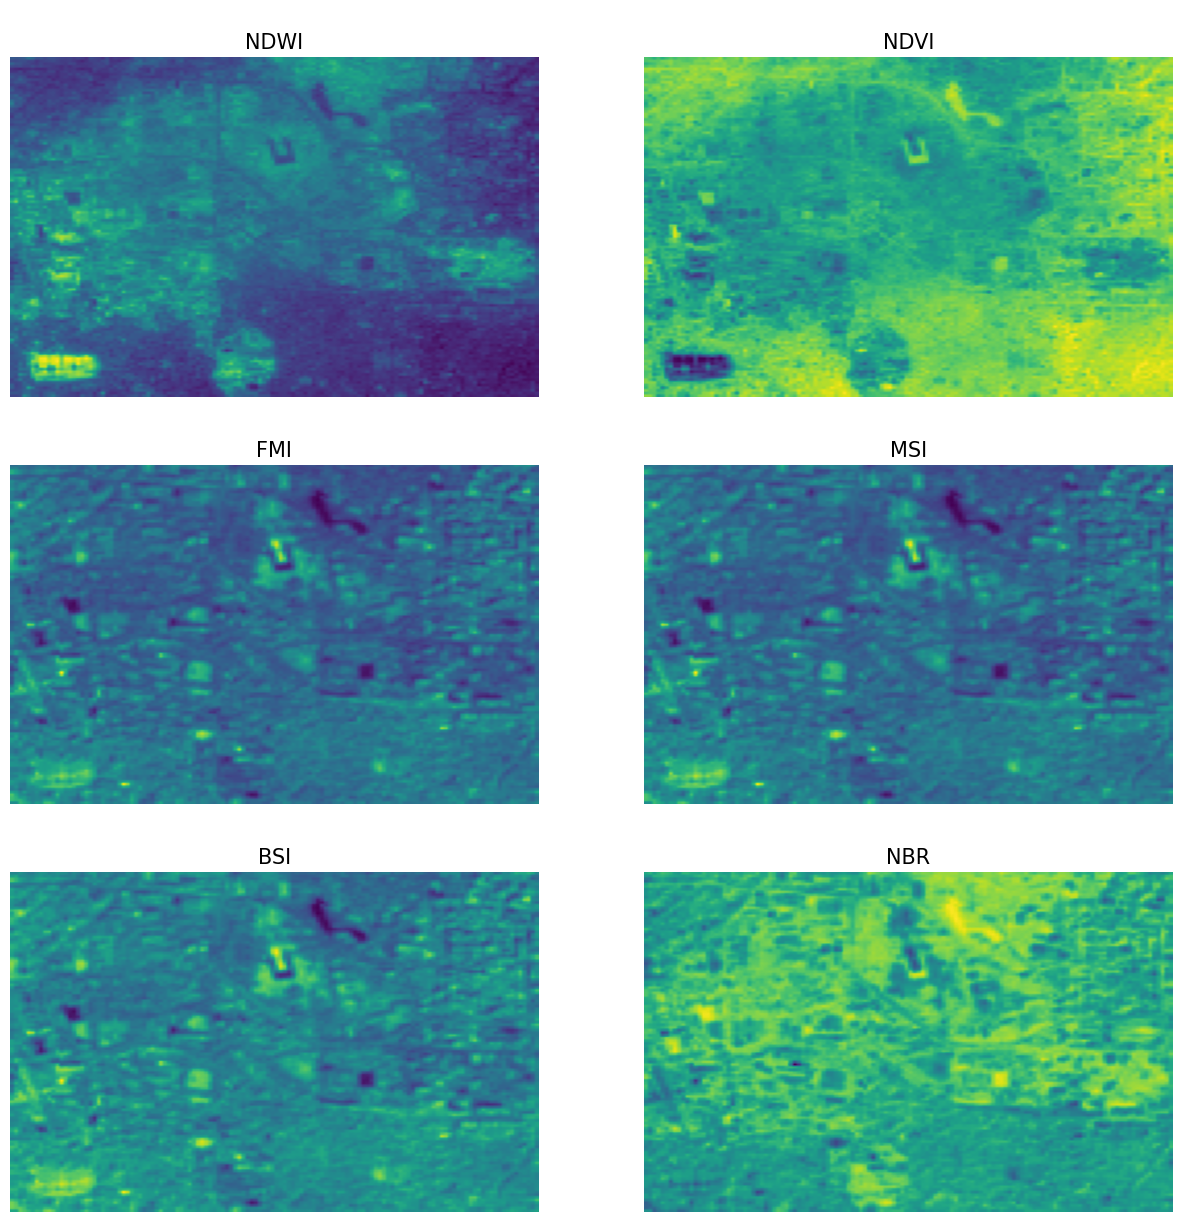

In [30]:
img = tifffile.imread(f"{train_image_path}{'train_3148.tif'}")
fig=plt.figure(figsize=(15,15))
for i,indices in enumerate((ndwi, ndvi, fmi, msi, bsi, nbr )):
    ax=plt.subplot(3,2,i+1)

    ax.imshow(indices(img), aspect='auto')


    ax.set_title(f"\n{indices.__name__.upper()}",fontsize=15)
    ax.axis("off")

### Let's calculate band-wise reflectance.
#### Mean reflectance is the amount of light that reflects off a surface, averaged across all pixels in a spectral band of an image.
#### A higher mean reflectance suggests a brighter or more reflective surface on average, while a lower mean reflectance indicates a darker or more absorbent surface.

In [31]:
def calculate_mean_reflectance(df, path):
    res = []
    for image in tqdm(df['filename']):
        im = tifffile.imread(f"{path}{image}")
        tmp = []
        for band in range(13):
            feature_mean = np.nanmean(im[:,:,band])
            feature_min = np.nanmin(im[:,:,band])
            feature_median = np.nanmedian(im[:,:,band])
            feature_max = np.nanmax(im[:,:,band])
            feature_std = np.nanstd(im[:,:,band])
            feature_var = np.nanvar(im[:,:,band])
            feature_skew = skew(im[:,:,band].flatten(), nan_policy='omit')
            feature_kurt = kurtosis(im[:,:,band].flatten(), nan_policy='omit')

            tmp.extend([feature_mean, feature_min, feature_median, feature_max,
                    feature_std, feature_var, feature_skew, feature_kurt])
        res.append(tmp)
    # Statistical measures to calculate
    stats = ["mean", "min", "median", "max", "std", "var", "skew", "kurt"]

    # Generate new column names
    new_columns = [f"band_{index}_{stat}" for index in range(13) for stat in stats]
    return pd.DataFrame(res, columns = new_columns)


In [32]:
band_wise_reflectance = calculate_mean_reflectance(train, train_image_path)

100%|██████████| 4465/4465 [04:03<00:00, 18.30it/s]


### Band wise mean reflectance correlation

In [33]:
mean_reflectance = band_wise_reflectance.filter(like = 'mean')

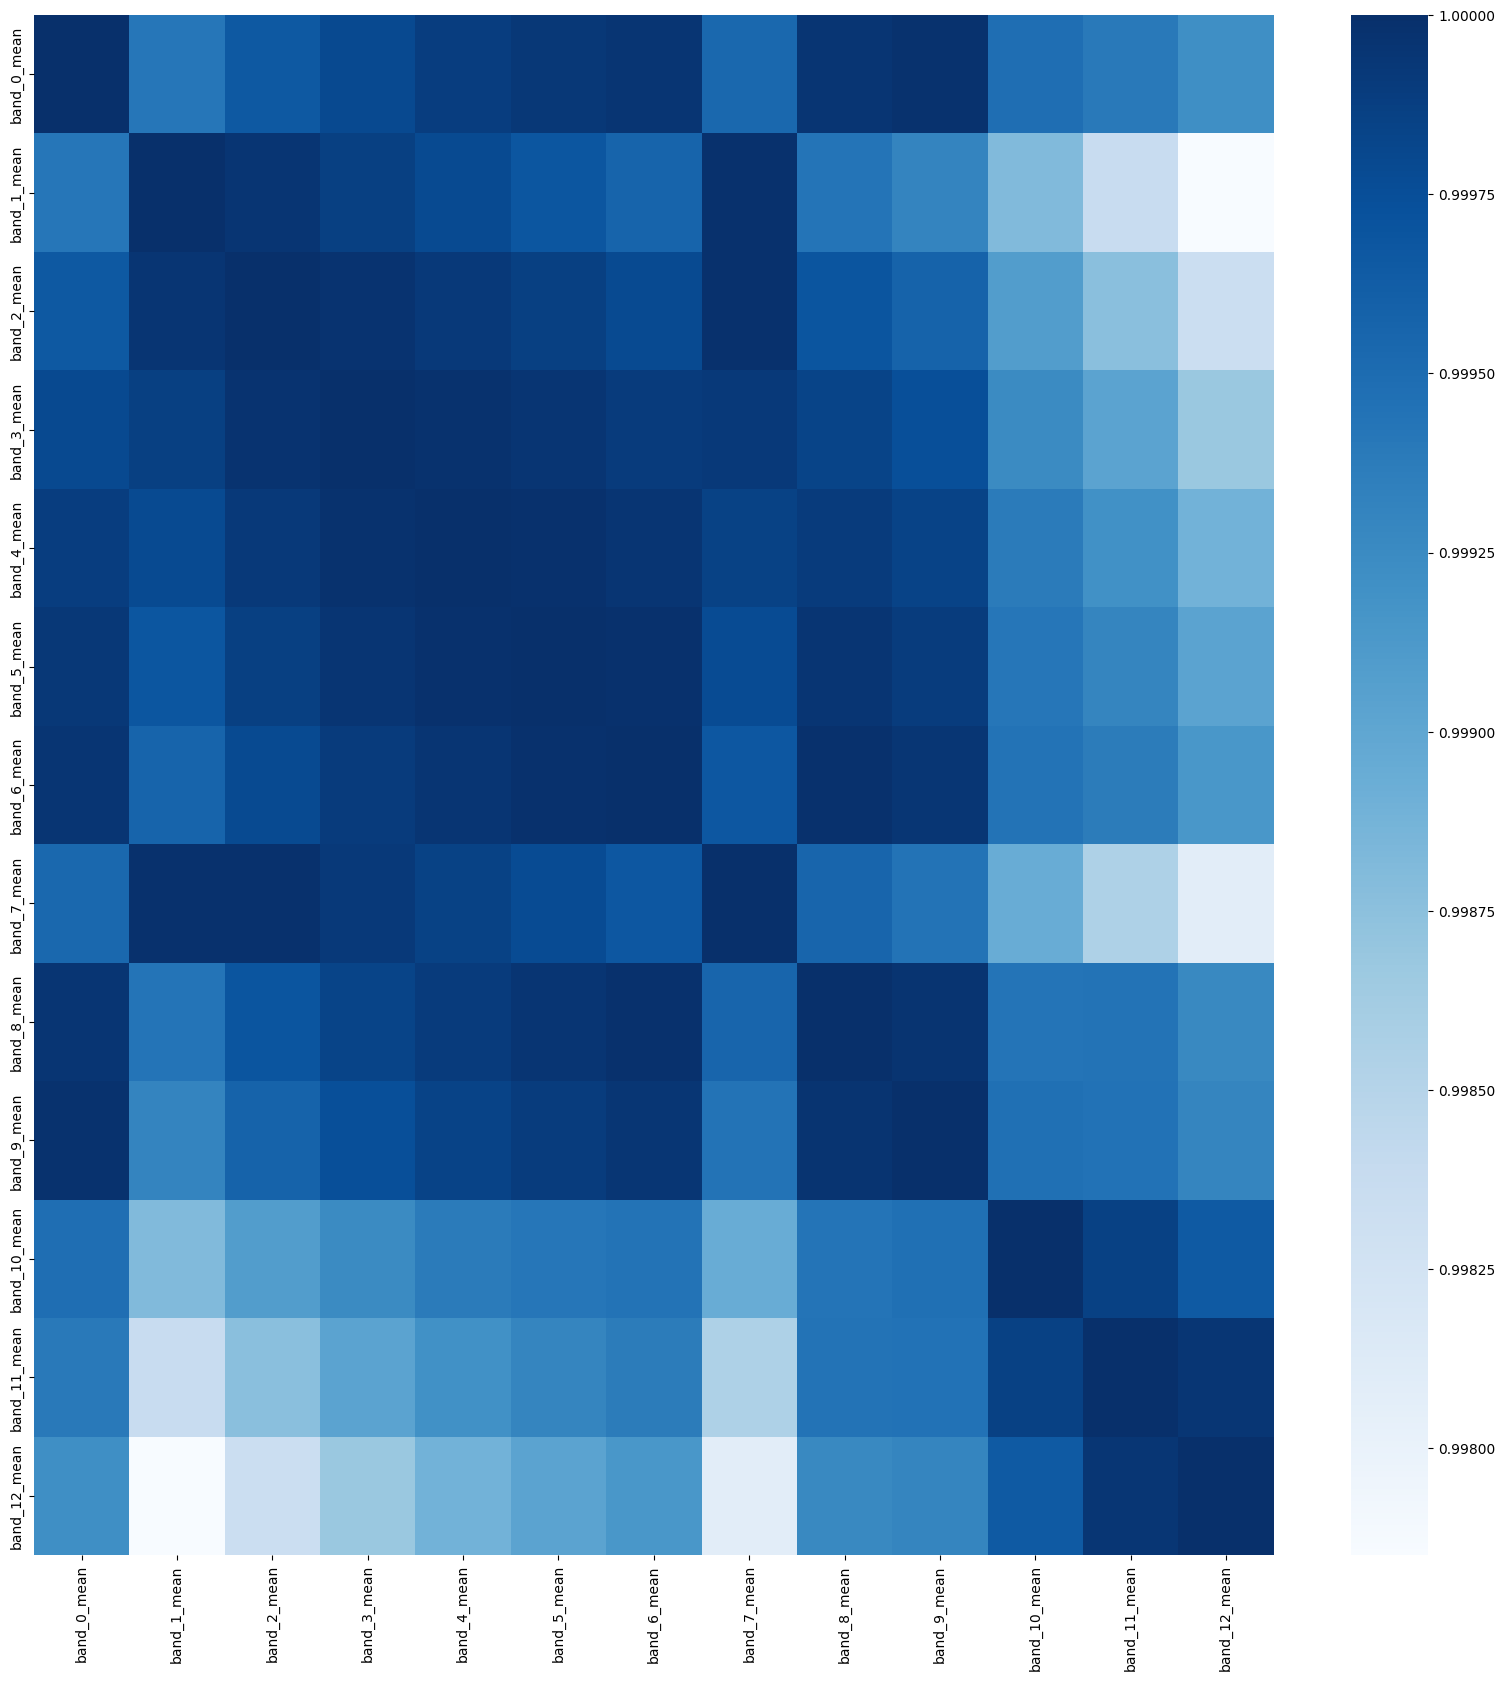

In [34]:
fig=plt.figure(figsize=(20,20))
sns.heatmap(mean_reflectance.corr(),
           cmap = 'Blues');

#### The mean reflectance of all bands is highly correlated among them.

### Gray-Level Co-occurrence Matrix (GLCM): Texture features
#### GLCM is a popular method for extracting texture information by analyzing pixel relationships at different spatial distances and angles.

- Contrast: Measures the intensity contrast between a pixel and its neighbor across the GLCM. Higher contrast values indicate more pronounced differences in intensity.


- Dissimilarity: Calculates the absolute difference between neighboring pixel values. It reflects how dissimilar the intensities of neighboring pixels are.

- Homogeneity: Measures the similarity of pixel values. Homogeneity is high when similar intensity values are close to each other.

- ASM (Angular Second Moment): ASM measures the uniformity of pixel pairs. Higher ASM indicates less texture variation.

- Energy: Represents the square root of ASM and also indicates textural uniformity. Higher values reflect more uniform and less complex textures.

- Correlation: Measures the correlation between pixels in a GLCM, indicating how pixel values relate to each other. High correlation suggests a linear dependency between pixel values.

In [35]:
# Texture Features
def extract_texture_features(pixels):
    features = []
    for i in range(pixels.shape[2]):
        band = pixels[:, :, i]

        # Ensure there are no zero bands to avoid division by zero
        if np.max(band) == 0:
            continue

        # Rescale the band to 8 levels for GLCM computation (0-7)
        band_rescaled = (band / np.max(band) * 7).astype(np.uint8)

        # Make sure that max value is less than 'levels'
        band_rescaled = np.clip(band_rescaled, 0, 7)

        # Compute GLCM for the rescaled band (distance=1, angle=0 degree)
        glcm = graycomatrix(band_rescaled, distances=[1], angles=[0], levels=8, symmetric=True, normed=True)

        # Extract texture features
        features.append([
            graycoprops(glcm, 'homogeneity')[0, 0],    #['homogeneity','contrast','dissimilarity','ASM','energy','correlation']
            graycoprops(glcm, 'contrast')[0, 0],
            graycoprops(glcm, 'dissimilarity')[0, 0],
            graycoprops(glcm, 'ASM')[0, 0],
            graycoprops(glcm, 'energy')[0, 0],
            graycoprops(glcm, 'correlation')[0, 0]
        ])
    mean_features = np.mean(features, axis=0)

    return mean_features

In [36]:
def get_texture_features(df,path):
    res = []
    for img in tqdm(df['filename']):
        im = tifffile.imread(f"{path}{img}")
        res.append(extract_texture_features(im))

    return pd.DataFrame(res,columns=['homogeneity','contrast','dissimilarity','ASM','energy','correlation'])

In [37]:
txt_feat = get_texture_features(train,train_image_path)

100%|██████████| 4465/4465 [01:49<00:00, 40.91it/s]


### Texture features correlation

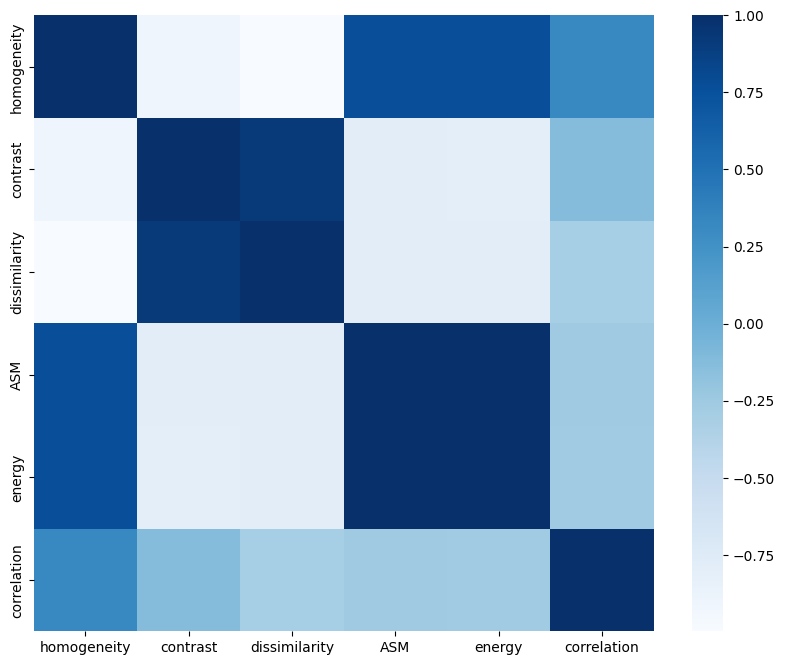

In [38]:

fig=plt.figure(figsize=(10,8))
sns.heatmap(txt_feat.corr(),
           cmap = 'Blues');

In [39]:
txt_feat.describe()

homogeneity     contrast  dissimilarity          ASM       energy  \
count  4465.000000  4465.000000    4465.000000  4465.000000  4465.000000   
mean      0.900327     0.227871       0.203833     0.388128     0.605065   
std       0.034236     0.081479       0.069744     0.130177     0.098938   
min       0.799120     0.010581       0.003208     0.149421     0.381379   
25%       0.875479     0.175083       0.159297     0.296785     0.534420   
50%       0.899316     0.227736       0.205089     0.366064     0.594319   
75%       0.922050     0.281941       0.253866     0.448448     0.659530   
max       0.998982     0.604776       0.418250     0.994246     0.997119   

       correlation  
count  4465.000000  
mean      0.731141  
std       0.110532  
min       0.218939  
25%       0.653189  
50%       0.704904  
75%       0.789454  
max       0.996525

###  Optimal cluster

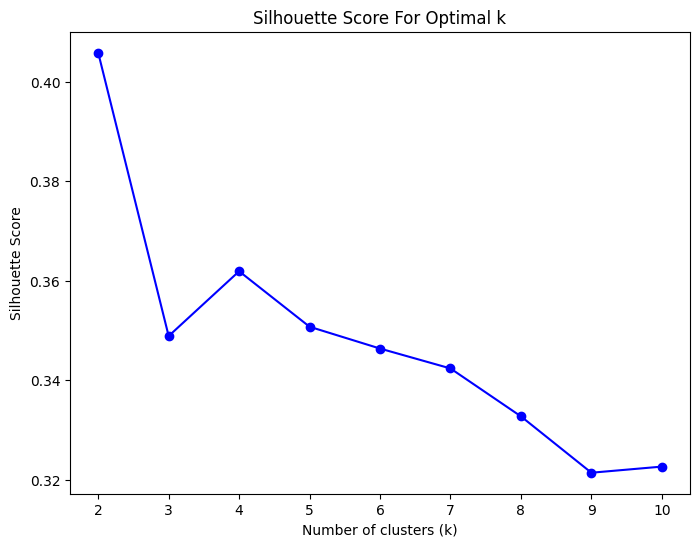

In [40]:
silhouette_scores = []

for k in range(2, 11):  # k must be at least 2 for silhouette score
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(txt_feat)
    score = silhouette_score(txt_feat, labels)
    silhouette_scores.append(score)

# Plotting the silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.show()

### Kmeans with optimal cluster

In [41]:
kmeans = KMeans(n_clusters=2, random_state=42)
txt_feat['clus'] = kmeans.fit_predict(txt_feat)

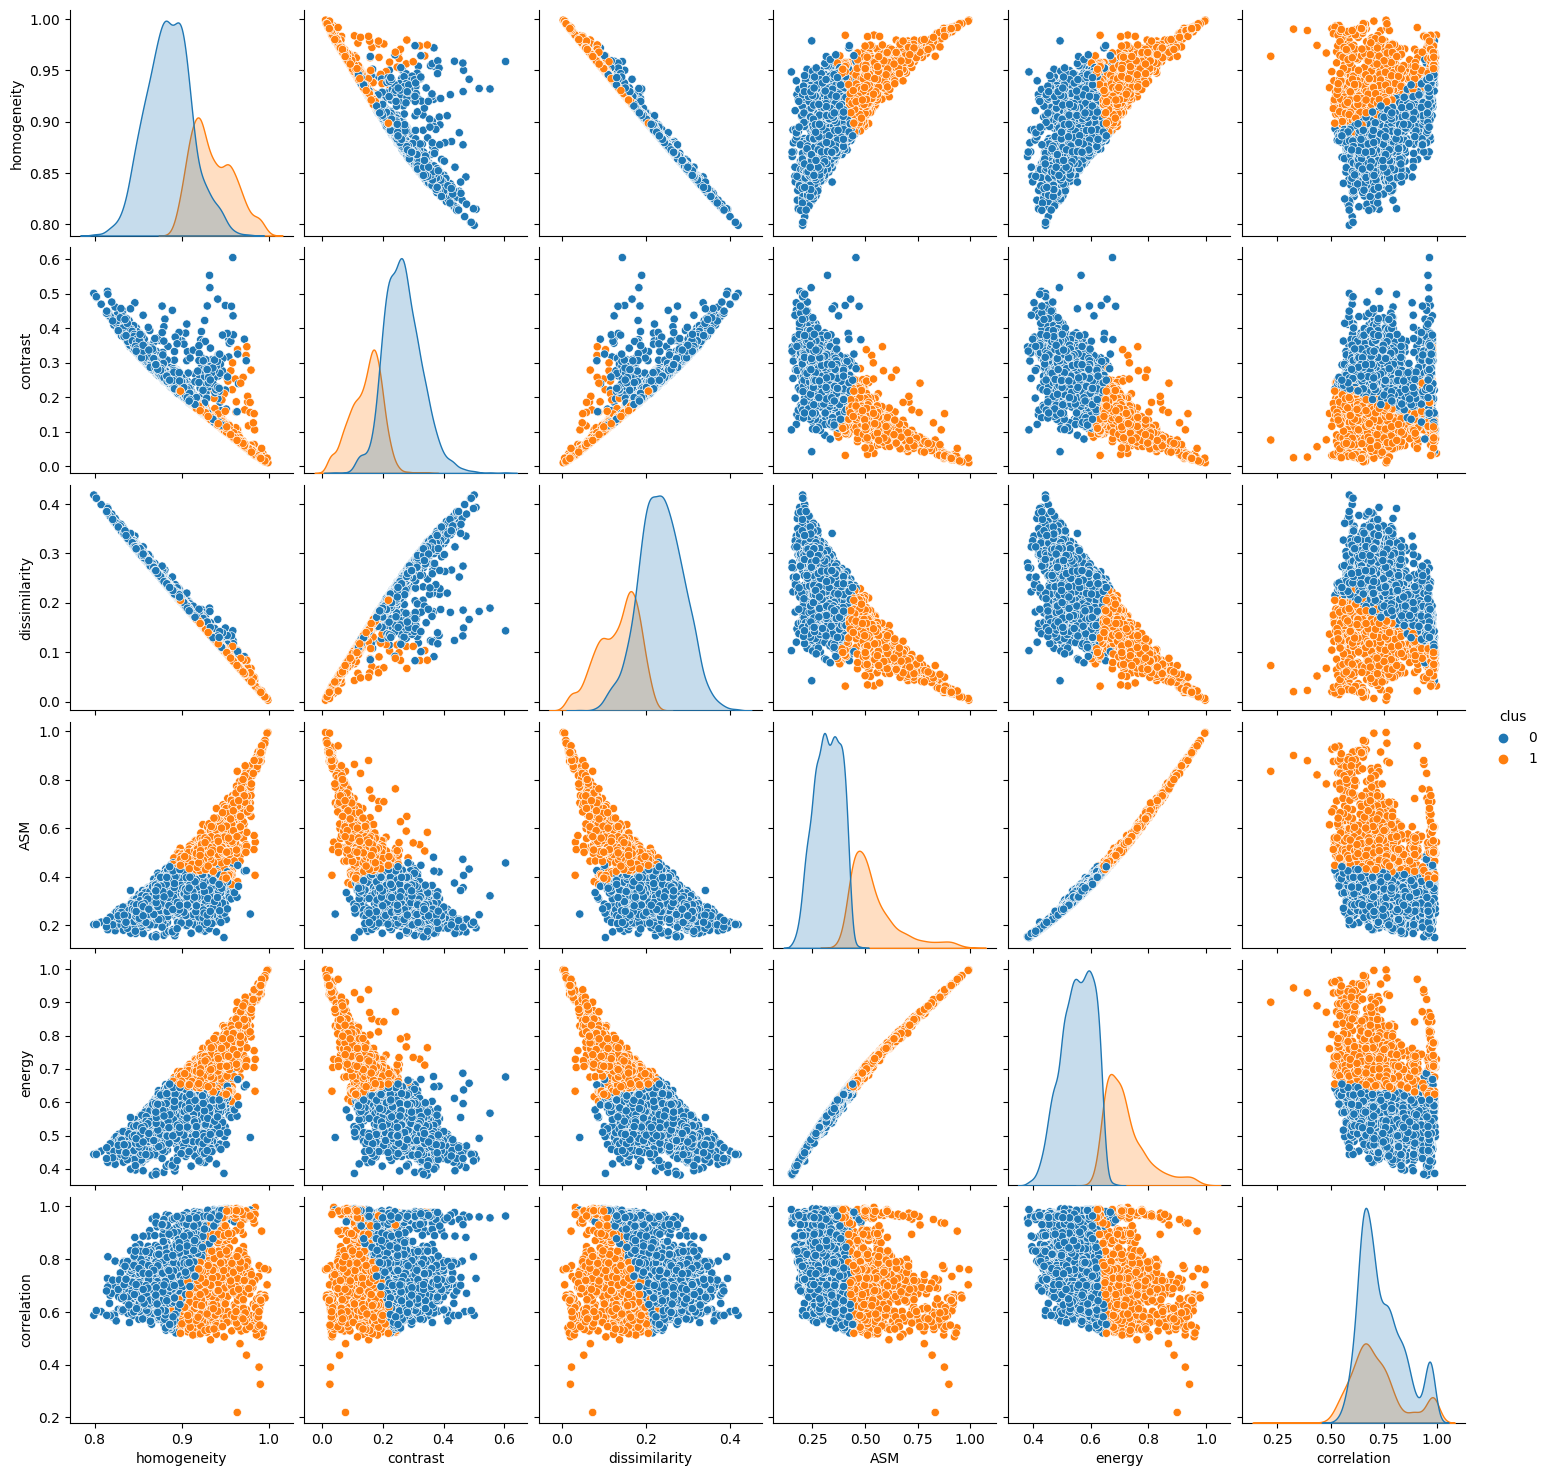

In [42]:
sns.pairplot(txt_feat,hue='clus');

####  Two distinct clusters have been identified based on the calculated textural features from the GLCM. These clusters indicate that the images contain two different patterns.